In [19]:
!pip install cloudpickle

import matplotlib.pyplot as plt
import shap
shap.initjs()
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import cloudpickle as rick

import lime
import lime.lime_tabular
# plt.style.use()

In [2]:
df = pd.read_csv("../datasets/09-12-2021_20-48-36.csv")
print(len(df))
df

540364


,Unnamed: 0,hour,minute,second,relative_time,temperature,mean_temp_day,heatindex,relative_humidity,light_sensor_one_wavelength,light_sensor_two_wavelength,number_occupants,activity_occupants,door_state,window_state,target,room_A,room_B,room_C
0,486159,10,59,50,572,22.10,3.1,21.453399,37.472,197.14,588.8,1,4,0,0,0,0,0,1
1,498156,16,3,36,2795,22.27,3.1,21.690846,41.117,175.71,437.0,0,0,0,0,0,0,0,1
2,257373,9,30,19,1484,21.42,10.4,21.334467,55.737,205.71,708.4,0,0,1,0,1,1,0,0
3,380814,14,22,26,6435,23.25,9.5,22.461804,41.603,184.29,414.0,0,0,0,0,0,0,1,0
4,188312,11,31,54,3339,23.24,13.0,23.010511,56.993,255.71,1062.6,2,4,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540359,32394,11,29,56,236,20.97,6.0,20.947466,46.949,270.00,1099.4,0,0,0,0,0,1,0,0
540360,237009,10,30,2,422,20.75,9.8,20.847739,51.688,188.57,529.0,0,0,1,0,0,1,0,0
540361,4623,10,4,26,4619,21.08,4.0,20.972212,44.236,182.86,556.6,2,1,0,0,0,1,0,0
540362,125539,10,27,5,5019,21.15,8.1,21.077712,48.083,250.00,864.8,2,1,0,0,1,1,0,0


In [3]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('../datasets/09-12-2021_20-48-36.csv', sep=',', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.9985074626865671
exported_pipeline = make_pipeline(
    VarianceThreshold(threshold=0.005),
    GradientBoostingClassifier(learning_rate=0.5, max_depth=8, max_features=0.45, min_samples_leaf=5, min_samples_split=18, n_estimators=100, subsample=0.9000000000000001)
)
exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

In [4]:
exported_pipeline.steps[len(exported_pipeline.steps)-1][1]

GradientBoostingClassifier(learning_rate=0.5, max_depth=8, max_features=0.45,
                           min_samples_leaf=5, min_samples_split=18,
                           subsample=0.9000000000000001)

In [5]:
def model_predict(data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=features.columns)
    return exported_pipeline.predict_proba(data_asframe)

In [ ]:
end = int(len(features)*0.10)
print(end)
exfeat = features.iloc[:end]
print(exfeat.shape)
explainer = shap.Explainer(model_predict, exfeat)
shap_test = explainer(exfeat)
# explainer = shap.KernelExplainer(model_predict, exfeat)
# shap_test = explainer.shap_values(exfeat)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

54036
(54036, 18)



Permutation explainer:   1%|          | 5783/540364 [12:57<20:21:52,  7.29it/s]A

Permutation explainer:  23%|██▎       | 12306/54036 [22:44<1:19:45,  8.72it/s]

In [7]:
# #set the tree explainer as the model of the pipeline
# explainer = shap.KernelExplainer(exported_pipeline.predict_proba, features)
# #apply the preprocessing to x_test
# observations = exported_pipeline.transform(features)
#
# #get Shap values from preprocessed data
# shap_values = explainer.shap_values(observations)
#
# #plot the feature importance
# shap.summary_plot(shap_values, features, plot_type="bar")

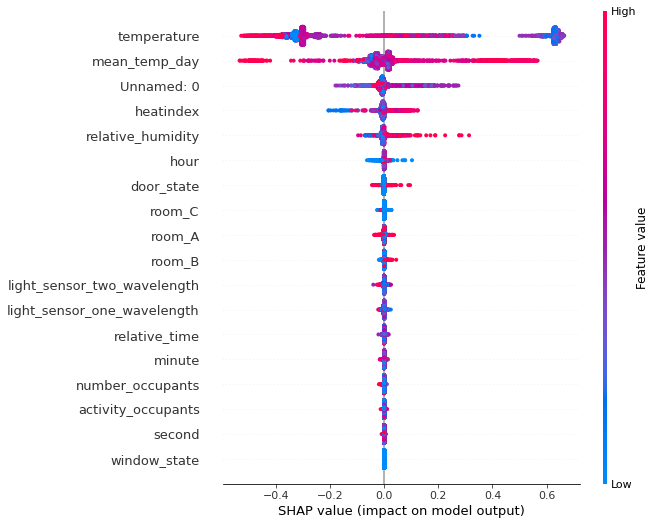

In [9]:
shap.summary_plot(shap_test, exfeat)

In [32]:
with open('shap.pkl', 'wb') as f:
    rick.dump(explainer, f)

with open('shapdata.pkl', 'wb') as f:
    rick.dump(shap_test, f)

In [33]:
with open('shap.pkl','rb') as f:
    shap_pkl = rick.load(f)

with open('shapdata.pkl', "rb") as f:
    shap_values_pkl = rick.load(f)

In [38]:
shap.plots.force(shap_values_pkl[4500])

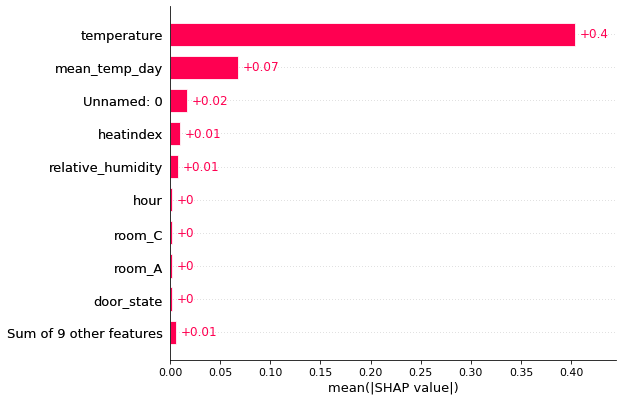

In [37]:
shap.plots.bar(shap_values_pkl)